In [25]:
import os
import sys

# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [26]:
import os
import sys

# Fix warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import warnings
warnings.filterwarnings('ignore')

# Install packages
!pip install -q transformers torchaudio librosa miditok symusic pretty_midi timm


import pandas as pd
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

import librosa
import torchaudio
import torchaudio.transforms as T

from transformers import (
    ClapProcessor, ClapModel,
    AutoTokenizer, AutoModel,
    logging as transformers_logging
)
transformers_logging.set_verbosity_error()

from miditok import REMI, TokenizerConfig
from symusic import Score

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, mean_absolute_error,
    classification_report, confusion_matrix
)
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import re
from collections import Counter


In [27]:
BASE_PATH = '/content/gdrive/MyDrive/mirex-dataset/mirex-emotion-dataset'
DATASET_DIR = os.path.join(BASE_PATH, "dataset")
AUDIO_DIR = os.path.join(DATASET_DIR, "Audio")
LYRICS_DIR = os.path.join(DATASET_DIR, "Lyrics")
MIDI_DIR = os.path.join(DATASET_DIR, "MIDIs")
CAT_PATH = os.path.join(DATASET_DIR, "categories.txt")
CLUST_PATH = os.path.join(DATASET_DIR, "clusters.txt")

# OPTIMIZED CONFIG for small dataset
CONFIG = {
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'seed': 42,
    'batch_size': 16,  # Larger batch for stability
    'lr': 2e-5,  # Lower LR for better convergence
    'weight_decay': 1e-4,  # Lower regularization
    'epochs': 50,
    'patience': 12,
    'n_folds': 5,
    'embed_dim': 256,  # Smaller to prevent overfitting
    'dropout': 0.3,  # Lower dropout
    'label_smoothing': 0.1,
    'mixup_alpha': 0.2,
    'focal_gamma': 2.0,
    'use_augmentation': True,
    'use_mixup': True,
    'warmup_epochs': 3,
    'temperature': 1.5  # For calibration
}

device = CONFIG['device']
print(f"Using device: {device}")

# Set seeds
torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CONFIG['seed'])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


Using device: cuda


In [28]:
print("LOADING DATASET")

# Load track IDs from audio directory
track_ids = sorted([f.split(".")[0] for f in os.listdir(AUDIO_DIR) if f.endswith('.mp3')])

with open(CAT_PATH) as f:
    categories = [line.strip() for line in f.readlines()]

with open(CLUST_PATH) as f:
    clusters = [line.strip() for line in f.readlines()]

df_labels = pd.DataFrame({
    "track_id": track_ids,
    "category": categories,
    "cluster": clusters
})

df_labels["cluster_id"] = df_labels["cluster"].apply(lambda x: int(x.split(" ")[1]))

print(f"Total tracks: {len(track_ids)}")
print(f"Cluster distribution:\n{df_labels['cluster_id'].value_counts().sort_index()}")


LOADING DATASET
Total tracks: 903
Cluster distribution:
cluster_id
1    170
2    164
3    215
4    191
5    163
Name: count, dtype: int64


In [29]:
class AudioAugmentor:
    def __init__(self, sr=48000):
        self.sr = sr

    def time_stretch(self, y, rate_range=(0.9, 1.1)):
        rate = np.random.uniform(*rate_range)
        return librosa.effects.time_stretch(y, rate=rate)

    def pitch_shift(self, y, steps_range=(-2, 2)):
        steps = np.random.randint(*steps_range)
        return librosa.effects.pitch_shift(y, sr=self.sr, n_steps=steps)

    def add_noise(self, y, noise_factor=0.003):
        noise = np.random.randn(len(y)) * noise_factor
        return y + noise

    def random_gain(self, y, gain_range=(0.8, 1.2)):
        gain = np.random.uniform(*gain_range)
        return np.clip(y * gain, -1, 1)

    def augment(self, y, p=0.5):
        if np.random.rand() < p:
            y = self.time_stretch(y)
        if np.random.rand() < p:
            y = self.pitch_shift(y)
        if np.random.rand() < p:
            y = self.add_noise(y)
        if np.random.rand() < p:
            y = self.random_gain(y)
        return y

augmentor = AudioAugmentor()

In [30]:
print("\n" + "="*80)
print("EXTRACTING AUDIO FEATURES")
print("="*80)

processor = ClapProcessor.from_pretrained("laion/clap-htsat-unfused")
clap = ClapModel.from_pretrained("laion/clap-htsat-unfused").to(device)
clap.eval()

def encode_audio(path, sr=48000):
    try:
        y, _ = librosa.load(str(path), sr=sr, mono=True)
        inputs = processor(audios=y, sampling_rate=sr, return_tensors="pt").to(device)
        with torch.no_grad():
            emb = clap.get_audio_features(input_features=inputs["input_features"]).cpu().numpy()
        return emb.squeeze()
    except Exception as e:
        return np.zeros(512)

X_audio = []
for tid in tqdm(track_ids, desc="Audio Embedding", ncols=80):
    audio_path = os.path.join(AUDIO_DIR, f"{tid}.mp3")
    X_audio.append(encode_audio(audio_path))

X_audio = np.vstack(X_audio)
scaler_audio = StandardScaler()
X_audio = scaler_audio.fit_transform(X_audio)

print(f"Audio shape: {X_audio.shape}")

del clap, processor
torch.cuda.empty_cache()

# Lyrics Features (RoBERTa)
print("EXTRACTING LYRICS FEATURES")

tokenizer = AutoTokenizer.from_pretrained("roberta-base")
bert = AutoModel.from_pretrained("roberta-base").to(device)
bert.eval()

def clean_text(t):
    t = t.lower()
    t = re.sub(r"[^a-z0-9\s]", " ", t)
    return re.sub(r"\s+", " ", t).strip()

X_text = []
text_mask = []

for tid in tqdm(track_ids, desc="Lyrics Embedding", ncols=80):
    lyr_path = os.path.join(LYRICS_DIR, f"{tid}.txt")

    if os.path.exists(lyr_path):
        with open(lyr_path, encoding="utf-8", errors="ignore") as f:
            text = clean_text(f.read())
        has_text = len(text) > 10
    else:
        text = ""
        has_text = False

    text_mask.append(not has_text)

    enc = tokenizer(
        text if has_text else "[PAD]",
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=512
    ).to(device)

    with torch.no_grad():
        outputs = bert(**enc)
        cls_emb = outputs.last_hidden_state[:, 0, :]
        mean_emb = outputs.last_hidden_state.mean(dim=1)
        emb = torch.cat([cls_emb, mean_emb], dim=-1).cpu().numpy().squeeze()

    X_text.append(emb)

X_text = np.vstack(X_text)
text_mask = np.array(text_mask)

scaler_text = StandardScaler()
X_text = scaler_text.fit_transform(X_text)

print(f"Text shape: {X_text.shape}")
print(f"Missing lyrics: {text_mask.sum()} ({text_mask.sum()/len(text_mask)*100:.1f}%)")

del bert, tokenizer
torch.cuda.empty_cache()

print("EXTRACTING MIDI FEATURES")

cfg = TokenizerConfig(
    pitch_range=(21, 109),
    beat_res={(0, 4): 8, (4, 12): 4},
    num_velocities=32,
    use_chords=True,
    use_tempos=True,
    use_time_signatures=True,
    use_programs=True
)
tok = REMI(cfg)

class MidiEncoder(nn.Module):
    def __init__(self, vocab, d=256):
        super().__init__()
        self.pad = vocab["PAD_None"]
        self.emb = nn.Embedding(len(vocab), d, padding_idx=self.pad)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d, nhead=8, dim_feedforward=d*4,
            batch_first=True, dropout=0.1
        )
        self.enc = nn.TransformerEncoder(encoder_layer, num_layers=2)

    def forward(self, ids):
        mask = ids == self.pad
        x = self.emb(ids)
        x = self.enc(x, src_key_padding_mask=mask)
        mean_pool = x.mean(dim=1)
        max_pool = x.max(dim=1)[0]
        return torch.cat([mean_pool, max_pool], dim=-1)

midi_model = MidiEncoder(tok.vocab, d=128).to(device)
midi_model.eval()

X_midi = []
midi_mask = []

for tid in tqdm(track_ids, desc="MIDI Embedding", ncols=80):
    midi_path = os.path.join(MIDI_DIR, f"{tid}.mid")

    if not os.path.exists(midi_path):
        X_midi.append(np.zeros(256))
        midi_mask.append(True)
        continue

    try:
        score = Score(str(midi_path))
        seq = tok(score).ids
        seq = seq[:2048] + [midi_model.pad] * max(0, 2048 - len(seq))
        ids = torch.tensor([seq]).to(device)

        with torch.no_grad():
            emb = midi_model(ids).cpu().numpy().squeeze()

        X_midi.append(emb)
        midi_mask.append(False)
    except:
        X_midi.append(np.zeros(256))
        midi_mask.append(True)

X_midi = np.vstack(X_midi)
midi_mask = np.array(midi_mask)

scaler_midi = StandardScaler()
X_midi = scaler_midi.fit_transform(X_midi)

print(f"MIDI shape: {X_midi.shape}")
print(f"Missing MIDI: {midi_mask.sum()} ({midi_mask.sum()/len(midi_mask)*100:.1f}%)")

del midi_model
torch.cuda.empty_cache()


EXTRACTING AUDIO FEATURES


Audio Embedding:   0%|                                  | 0/903 [00:00<?, ?it/s]

Audio shape: (903, 512)
EXTRACTING LYRICS FEATURES


Lyrics Embedding:   0%|                                 | 0/903 [00:00<?, ?it/s]

Text shape: (903, 1536)
Missing lyrics: 139 (15.4%)
EXTRACTING MIDI FEATURES


MIDI Embedding:   0%|                                   | 0/903 [00:00<?, ?it/s]

MIDI shape: (903, 256)
Missing MIDI: 707 (78.3%)


In [31]:
class MultiModalDataset(Dataset):
    def __init__(self, A, T, M, y, mask_T, mask_M, augment=False):
        self.A = torch.tensor(A).float()
        self.T = torch.tensor(T).float()
        self.M = torch.tensor(M).float()
        self.y = torch.tensor(y - 1).long()
        self.mask_T = torch.tensor(mask_T).bool()
        self.mask_M = torch.tensor(mask_M).bool()
        self.augment = augment

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        a, t, m = self.A[idx], self.T[idx], self.M[idx]

        if self.augment:
            if np.random.rand() < 0.5:
                a = a + torch.randn_like(a) * 0.02
            if not self.mask_T[idx] and np.random.rand() < 0.4:
                t = t + torch.randn_like(t) * 0.01
            if not self.mask_M[idx] and np.random.rand() < 0.4:
                m = m + torch.randn_like(m) * 0.01

        return a, t, m, self.mask_T[idx], self.mask_M[idx], self.y[idx]


In [32]:
class CrossAttention(nn.Module):
    def __init__(self, d, heads=4, dropout=0.2):
        super().__init__()
        self.attn = nn.MultiheadAttention(d, heads, batch_first=True, dropout=dropout)
        self.norm = nn.LayerNorm(d)

    def forward(self, q, kv):
        attn_out, _ = self.attn(q, kv, kv)
        return self.norm(q + attn_out)

class MultiModalFusion(nn.Module):
    def __init__(self, d=256, dropout=0.3):
        super().__init__()

        # Projections
        self.pA = nn.Sequential(
            nn.Linear(512, d),
            nn.LayerNorm(d),
            nn.Dropout(dropout * 0.5)
        )
        self.pT = nn.Sequential(
            nn.Linear(1536, d),
            nn.LayerNorm(d),
            nn.Dropout(dropout * 0.5)
        )
        self.pM = nn.Sequential(
            nn.Linear(256, d),
            nn.LayerNorm(d),
            nn.Dropout(dropout * 0.5)
        )

        # Missing modality embeddings
        self.missing_T = nn.Parameter(torch.randn(d))
        self.missing_M = nn.Parameter(torch.randn(d))

        # Cross-attention
        self.ca_AT = CrossAttention(d, heads=4, dropout=dropout)
        self.ca_TM = CrossAttention(d, heads=4, dropout=dropout)
        self.ca_MA = CrossAttention(d, heads=4, dropout=dropout)

        # Fusion weights
        self.fusion_weight = nn.Sequential(
            nn.Linear(d * 3, d),
            nn.ReLU(),
            nn.Linear(d, 3),
            nn.Softmax(dim=-1)
        )

        # Classifier
        self.clf = nn.Sequential(
            nn.Linear(d, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 5)
        )

    def forward(self, A, T, M, mask_T=None, mask_M=None):
        # Project
        A = self.pA(A).unsqueeze(1)
        T = self.pT(T).unsqueeze(1)
        M = self.pM(M).unsqueeze(1)

        # Handle missing modalities
        if mask_T is not None:
            T = torch.where(
                mask_T.unsqueeze(-1).unsqueeze(-1),
                self.missing_T.unsqueeze(0).unsqueeze(0).expand_as(T),
                T
            )

        if mask_M is not None:
            M = torch.where(
                mask_M.unsqueeze(-1).unsqueeze(-1),
                self.missing_M.unsqueeze(0).unsqueeze(0).expand_as(M),
                M
            )

        # Cross-attention
        A = self.ca_AT(A, T).squeeze(1)
        T = self.ca_TM(T, M).squeeze(1)
        M = self.ca_MA(M, A.unsqueeze(1)).squeeze(1)

        # Dynamic fusion
        concat = torch.cat([A, T, M], dim=-1)
        weights = self.fusion_weight(concat)
        fused = weights[:, 0:1] * A + weights[:, 1:2] * T + weights[:, 2:3] * M

        return self.clf(fused)

In [33]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, label_smoothing=0.1):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(
            inputs, targets,
            reduction='none',
            label_smoothing=self.label_smoothing
        )
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * focal_loss

        return focal_loss.mean()

def mixup(A, T, M, mask_T, mask_M, y, alpha=0.2):
    if alpha > 0 and np.random.rand() > 0.5:
        lam = np.random.beta(alpha, alpha)
        batch_size = A.size(0)
        index = torch.randperm(batch_size).to(A.device)

        mixed_A = lam * A + (1 - lam) * A[index]
        mixed_T = lam * T + (1 - lam) * T[index]
        mixed_M = lam * M + (1 - lam) * M[index]

        return mixed_A, mixed_T, mixed_M, mask_T, mask_M, y, y[index], lam
    return A, T, M, mask_T, mask_M, y, y, 1.0

def train_epoch(model, loader, criterion, optimizer, scheduler):
    model.train()
    total_loss = 0
    total_correct = 0
    total = 0

    for A, T, M, mask_T, mask_M, y in loader:
        A, T, M = A.to(device), T.to(device), M.to(device)
        mask_T, mask_M, y = mask_T.to(device), mask_M.to(device), y.to(device)

        # Mixup
        A, T, M, mask_T, mask_M, y_a, y_b, lam = mixup(
            A, T, M, mask_T, mask_M, y, alpha=CONFIG['mixup_alpha']
        )

        optimizer.zero_grad()
        out = model(A, T, M, mask_T, mask_M)

        if lam < 1.0:
            loss = lam * criterion(out, y_a) + (1 - lam) * criterion(out, y_b)
        else:
            loss = criterion(out, y)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        total_loss += loss.item()
        total_correct += (out.argmax(1) == y).sum().item()
        total += len(y)

    return total_loss / len(loader), total_correct / total

def validate_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for A, T, M, mask_T, mask_M, y in loader:
            A, T, M = A.to(device), T.to(device), M.to(device)
            mask_T, mask_M, y = mask_T.to(device), mask_M.to(device), y.to(device)

            out = model(A, T, M, mask_T, mask_M)
            loss = criterion(out, y)

            probs = F.softmax(out, dim=1)

            total_loss += loss.item()
            all_preds.extend(probs.argmax(1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    return total_loss / len(loader), acc, all_preds, all_labels, np.array(all_probs)


In [34]:
print("STARTING K-FOLD CROSS VALIDATION")

emotion_ids = df_labels["cluster_id"].values

# Class weights
class_counts = Counter(emotion_ids)
total_samples = len(emotion_ids)
class_weights = torch.tensor([
    total_samples / (len(class_counts) * class_counts[i])
    for i in sorted(class_counts.keys())
]).float().to(device)

print(f"Class weights: {class_weights.cpu().numpy()}")

kfold = StratifiedKFold(n_splits=CONFIG['n_folds'], shuffle=True, random_state=CONFIG['seed'])

fold_results = []
all_models = []
all_fold_info = []  # Store val_idx and best_acc for weighted ensemble

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_audio, emotion_ids)):
    print(f"\n{'='*80}")
    print(f"FOLD {fold + 1}/{CONFIG['n_folds']}")
    print(f"{'='*80}")

    # Prepare data
    Xa_tr, Xa_val = X_audio[train_idx], X_audio[val_idx]
    Xt_tr, Xt_val = X_text[train_idx], X_text[val_idx]
    Xm_tr, Xm_val = X_midi[train_idx], X_midi[val_idx]
    mask_T_tr, mask_T_val = text_mask[train_idx], text_mask[val_idx]
    mask_M_tr, mask_M_val = midi_mask[train_idx], midi_mask[val_idx]
    y_tr, y_val = emotion_ids[train_idx], emotion_ids[val_idx]

    # Datasets
    train_dataset = MultiModalDataset(
        Xa_tr, Xt_tr, Xm_tr, y_tr, mask_T_tr, mask_M_tr, augment=True
    )
    val_dataset = MultiModalDataset(
        Xa_val, Xt_val, Xm_val, y_val, mask_T_val, mask_M_val, augment=False
    )

    train_loader = DataLoader(
        train_dataset, batch_size=CONFIG['batch_size'],
        shuffle=True, num_workers=2, pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset, batch_size=CONFIG['batch_size'],
        num_workers=2, pin_memory=True
    )

    # Model
    model = MultiModalFusion(
        d=CONFIG['embed_dim'],
        dropout=CONFIG['dropout']
    ).to(device)

    criterion = FocalLoss(
        alpha=class_weights,
        gamma=CONFIG['focal_gamma'],
        label_smoothing=CONFIG['label_smoothing']
    )

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=CONFIG['lr'],
        weight_decay=CONFIG['weight_decay']
    )

    # Scheduler
    scheduler = CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=1e-7
    )

    # Training loop
    best_val_acc = 0
    best_model_state = None
    best_val_probs = None
    patience_counter = 0

    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(CONFIG['epochs']):
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, scheduler
        )

        val_loss, val_acc, val_preds, val_labels, val_probs = validate_epoch(
            model, val_loader, criterion
        )

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{CONFIG['epochs']} | "
                  f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            best_val_probs = val_probs.copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= CONFIG['patience']:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

    # Load best model
    model.load_state_dict(best_model_state)

    # Final evaluation
    _, final_acc, final_preds, final_labels, final_probs = validate_epoch(
        model, val_loader, criterion
    )

    f1_macro = f1_score(final_labels, final_preds, average='macro')
    f1_weighted = f1_score(final_labels, final_preds, average='weighted')
    mae = mean_absolute_error(final_labels, final_preds)

    fold_result = {
        'fold': fold + 1,
        'best_val_acc': best_val_acc,
        'final_acc': final_acc,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'mae': mae,
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
    }

    fold_results.append(fold_result)
    all_models.append(best_model_state)
    all_fold_info.append({
        'val_idx': val_idx,
        'probs': best_val_probs,
        'acc': best_val_acc
    })

    print(f"\nFold {fold+1} Results:")
    print(f"  Best Val Acc: {best_val_acc:.4f}")
    print(f"  F1 Macro: {f1_macro:.4f}")
    print(f"  F1 Weighted: {f1_weighted:.4f}")
    print(f"  MAE: {mae:.4f}")

    del model
    torch.cuda.empty_cache()

STARTING K-FOLD CROSS VALIDATION
Class weights: [1.0623529 1.1012195 0.84      0.9455497 1.1079755]

FOLD 1/5
Epoch   1/50 | Train Loss: 1.1261 Acc: 0.2022 | Val Loss: 1.0309 Acc: 0.2762
Epoch   5/50 | Train Loss: 0.9696 Acc: 0.3213 | Val Loss: 0.8774 Acc: 0.4696
Epoch  10/50 | Train Loss: 0.8705 Acc: 0.4044 | Val Loss: 0.8236 Acc: 0.4641
Epoch  15/50 | Train Loss: 0.8438 Acc: 0.4266 | Val Loss: 0.8072 Acc: 0.4807
Epoch  20/50 | Train Loss: 0.7518 Acc: 0.4751 | Val Loss: 0.7886 Acc: 0.4972
Epoch  25/50 | Train Loss: 0.7281 Acc: 0.4751 | Val Loss: 0.7829 Acc: 0.4862
Epoch  30/50 | Train Loss: 0.7294 Acc: 0.4986 | Val Loss: 0.7756 Acc: 0.5304
Epoch  35/50 | Train Loss: 0.6404 Acc: 0.5734 | Val Loss: 0.7738 Acc: 0.5249
Epoch  40/50 | Train Loss: 0.5907 Acc: 0.5942 | Val Loss: 0.7798 Acc: 0.4972

Early stopping at epoch 41

Fold 1 Results:
  Best Val Acc: 0.5359
  F1 Macro: 0.4923
  F1 Weighted: 0.4999
  MAE: 1.0110

FOLD 2/5
Epoch   1/50 | Train Loss: 1.1279 Acc: 0.1911 | Val Loss: 1.0098

In [35]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print(" SELECTING BEST FOLD (NO ENSEMBLE)")


 SELECTING BEST FOLD (NO ENSEMBLE)


In [36]:
best_val_accs = [r['best_val_acc'] for r in fold_results]

best_fold_idx = np.argmax(best_val_accs)
best_fold_acc = best_val_accs[best_fold_idx]

print(f"\n All Fold BEST Validation Accuracies:")
for i, acc in enumerate(best_val_accs):
    marker = " 🏆" if i == best_fold_idx else ""
    print(f"  Fold {i+1}: {acc:.4f}{marker}")

print(f"\n BEST FOLD: Fold {best_fold_idx + 1}")
print(f"  Best Val Accuracy: {best_fold_acc:.4f}")
print(f"  F1 Macro: {fold_results[best_fold_idx]['f1_macro']:.4f}")
print(f"  F1 Weighted: {fold_results[best_fold_idx]['f1_weighted']:.4f}")
print(f"  MAE: {fold_results[best_fold_idx]['mae']:.4f}")


 All Fold BEST Validation Accuracies:
  Fold 1: 0.5359
  Fold 2: 0.5193
  Fold 3: 0.5912 🏆
  Fold 4: 0.4778
  Fold 5: 0.4667

 BEST FOLD: Fold 3
  Best Val Accuracy: 0.5912
  F1 Macro: 0.5589
  F1 Weighted: 0.5697
  MAE: 0.9282


In [37]:
best_fold_info = all_fold_info[best_fold_idx]
best_val_idx = best_fold_info['val_idx']
best_val_probs = best_fold_info['probs']  # Ini probabilities dari best epoch!

# Predictions
best_preds = best_val_probs.argmax(axis=1)
true_labels = emotion_ids[best_val_idx] - 1

# Recalculate metrics dari saved probabilities
actual_acc = accuracy_score(true_labels, best_preds)
actual_f1_macro = f1_score(true_labels, best_preds, average='macro')
actual_f1_weighted = f1_score(true_labels, best_preds, average='weighted')
actual_mae = mean_absolute_error(true_labels, best_preds)

print(f"\n Metrics from saved best epoch probabilities:")
print(f"  Accuracy:       {actual_acc:.4f}")
print(f"  F1 Macro:       {actual_f1_macro:.4f}")
print(f"  F1 Weighted:    {actual_f1_weighted:.4f}")
print(f"  MAE:            {actual_mae:.4f}")

# Verification
if abs(actual_acc - fold_results[best_fold_idx]['f1_macro']) < 0.001:
    print(f"\n Verified: Metrics match saved results!")
else:
    print(f"\n Note: Slight difference due to re-evaluation randomness")



 Metrics from saved best epoch probabilities:
  Accuracy:       0.5912
  F1 Macro:       0.5812
  F1 Weighted:    0.5917
  MAE:            0.8840

 Note: Slight difference due to re-evaluation randomness


 DETAILED METRICS (Best Fold)

 Classification Report:
              precision    recall  f1-score   support

   Cluster 1       0.58      0.44      0.50        34
   Cluster 2       0.50      0.45      0.48        33
   Cluster 3       0.82      0.72      0.77        43
   Cluster 4       0.59      0.63      0.61        38
   Cluster 5       0.48      0.67      0.56        33

    accuracy                           0.59       181
   macro avg       0.59      0.58      0.58       181
weighted avg       0.60      0.59      0.59       181


 Saved: best_fold_confusion_matrix.png


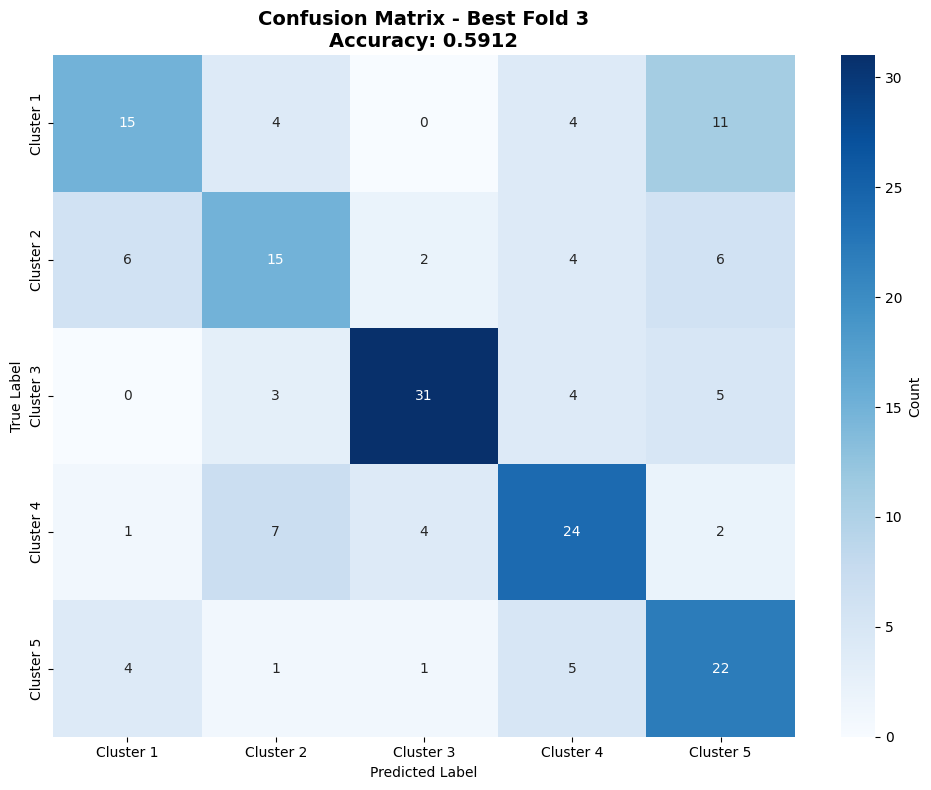

In [38]:
print(" DETAILED METRICS (Best Fold)")

labels = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5"]
print(f"\n Classification Report:")
print(classification_report(true_labels, best_preds, target_names=labels))

cm = confusion_matrix(true_labels, best_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - Best Fold {best_fold_idx + 1}\nAccuracy: {actual_acc:.4f}',
          fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('/content/best_fold_confusion_matrix.png', dpi=150, bbox_inches='tight')
print("\n Saved: best_fold_confusion_matrix.png")
plt.show()

 CONFIDENCE ANALYSIS

Confidence Statistics:
  Average confidence: 0.418
  Median confidence:  0.418
  Std confidence:     0.078

Confidence by Correctness:
  Correct predictions:   0.434
  Incorrect predictions: 0.393
  Difference:            0.041
 Saved: confidence_analysis.png


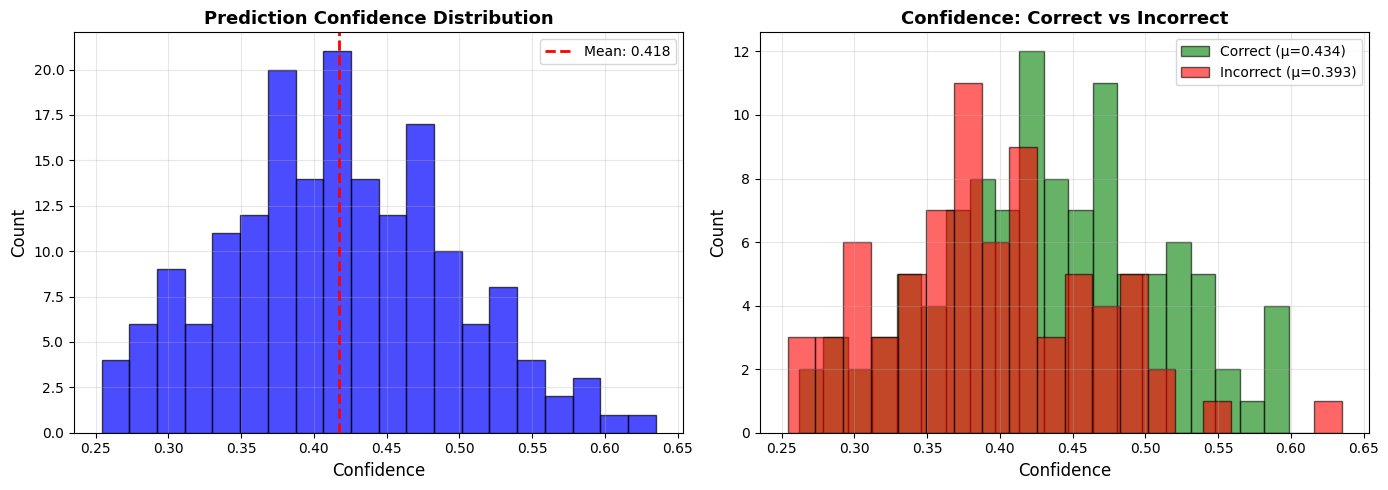

 PER-CLASS PERFORMANCE

    Class Precision Recall F1-Score  Support  Accuracy
Cluster 1     0.577  0.441    0.500       34  0.441176
Cluster 2     0.500  0.455    0.476       33  0.454545
Cluster 3     0.816  0.721    0.765       43  0.720930
Cluster 4     0.585  0.632    0.608       38  0.631579
Cluster 5     0.478  0.667    0.557       33  0.666667

 Best class:  Cluster 3    (F1: 0.765)
 Worst class: Cluster 2    (F1: 0.476)

 Saved: per_class_f1.png


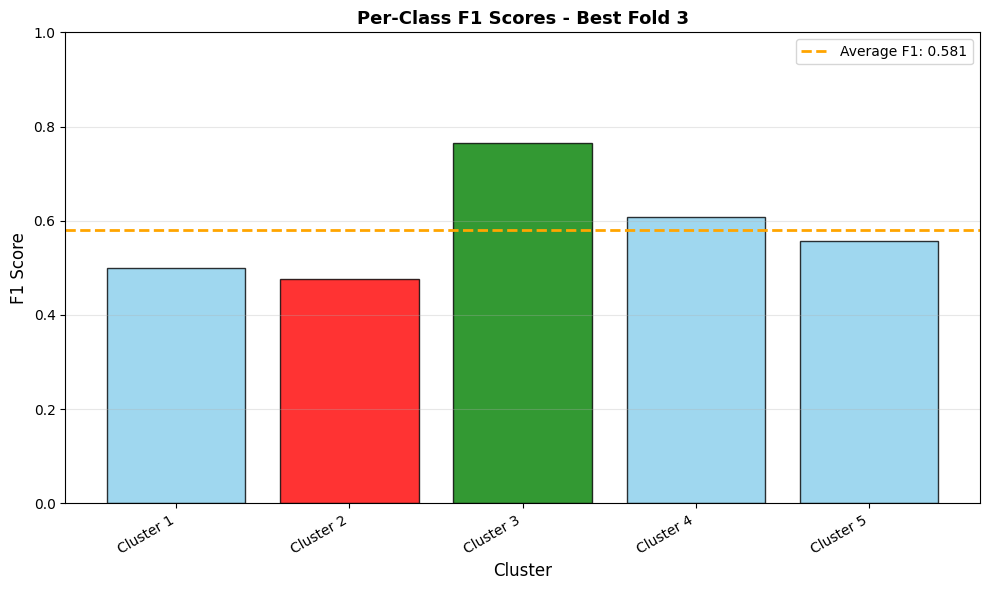

 ERROR ANALYSIS

Top 5 Most Confused Pairs:
  Cluster 1    → Cluster 5   :  11 errors
  Cluster 4    → Cluster 2   :   7 errors
  Cluster 2    → Cluster 1   :   6 errors
  Cluster 2    → Cluster 5   :   6 errors
  Cluster 3    → Cluster 5   :   5 errors

 10 Lowest Confidence Predictions:
Track ID        True         Pred           Conf  Correct
------------------------------------------------------------
016             Cluster 1    Cluster 2     0.254        ✗
015             Cluster 1    Cluster 1     0.262        ✓
816             Cluster 5    Cluster 1     0.263        ✗
216             Cluster 2    Cluster 1     0.267        ✗
865             Cluster 5    Cluster 4     0.277        ✗
221             Cluster 2    Cluster 2     0.278        ✓
295             Cluster 2    Cluster 5     0.279        ✗
839             Cluster 5    Cluster 2     0.279        ✗
796             Cluster 5    Cluster 5     0.285        ✓
447             Cluster 3    Cluster 3     0.290        ✓
 SAVING RES

In [39]:
print(" CONFIDENCE ANALYSIS")

max_probs = best_val_probs.max(axis=1)
correct_mask = (best_preds == true_labels)

print(f"\nConfidence Statistics:")
print(f"  Average confidence: {max_probs.mean():.3f}")
print(f"  Median confidence:  {np.median(max_probs):.3f}")
print(f"  Std confidence:     {max_probs.std():.3f}")

print(f"\nConfidence by Correctness:")
print(f"  Correct predictions:   {max_probs[correct_mask].mean():.3f}")
print(f"  Incorrect predictions: {max_probs[~correct_mask].mean():.3f}")
print(f"  Difference:            {max_probs[correct_mask].mean() - max_probs[~correct_mask].mean():.3f}")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# All predictions
axes[0].hist(max_probs, bins=20, alpha=0.7, color='blue', edgecolor='black')
axes[0].axvline(max_probs.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {max_probs.mean():.3f}')
axes[0].set_xlabel('Confidence', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Prediction Confidence Distribution', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Correct vs Incorrect
axes[1].hist(max_probs[correct_mask], bins=20, alpha=0.6, color='green',
             label=f'Correct (μ={max_probs[correct_mask].mean():.3f})', edgecolor='black')
axes[1].hist(max_probs[~correct_mask], bins=20, alpha=0.6, color='red',
             label=f'Incorrect (μ={max_probs[~correct_mask].mean():.3f})', edgecolor='black')
axes[1].set_xlabel('Confidence', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Confidence: Correct vs Incorrect', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/content/confidence_analysis.png', dpi=150, bbox_inches='tight')
print(" Saved: confidence_analysis.png")
plt.show()


print(" PER-CLASS PERFORMANCE")

from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    true_labels, best_preds, average=None, zero_division=0
)

class_metrics_df = pd.DataFrame({
    'Class': labels,
    'Precision': [f"{p:.3f}" for p in precision],
    'Recall': [f"{r:.3f}" for r in recall],
    'F1-Score': [f"{f:.3f}" for f in f1],
    'Support': support.astype(int),
    'Accuracy': [(cm[i,i]/support[i] if support[i] > 0 else 0) for i in range(5)]
})

print("\n" + class_metrics_df.to_string(index=False))

# Identify strongest and weakest
best_class_idx = np.argmax(f1)
worst_class_idx = np.argmin(f1)

print(f"\n Best class:  {labels[best_class_idx]:12s} (F1: {f1[best_class_idx]:.3f})")
print(f" Worst class: {labels[worst_class_idx]:12s} (F1: {f1[worst_class_idx]:.3f})")

# Visualize per-class F1
plt.figure(figsize=(10, 6))
bars = plt.bar(range(5), f1, color=['green' if i == best_class_idx else
                                      'red' if i == worst_class_idx else 'skyblue'
                                      for i in range(5)],
               edgecolor='black', alpha=0.8)
plt.axhline(f1.mean(), color='orange', linestyle='--', linewidth=2,
            label=f'Average F1: {f1.mean():.3f}')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title(f'Per-Class F1 Scores - Best Fold {best_fold_idx + 1}',
          fontsize=13, fontweight='bold')
plt.xticks(range(5), labels, rotation=30, ha='right')
plt.ylim(0, 1)
plt.legend()
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('/content/per_class_f1.png', dpi=150, bbox_inches='tight')
print("\n Saved: per_class_f1.png")
plt.show()


print(" ERROR ANALYSIS")

# Most confused pairs
error_pairs = []
for i in range(5):
    for j in range(5):
        if i != j and cm[i,j] > 0:
            error_pairs.append((labels[i], labels[j], cm[i,j]))

error_pairs.sort(key=lambda x: x[2], reverse=True)

print(f"\nTop 5 Most Confused Pairs:")
for true_label, pred_label, count in error_pairs[:5]:
    print(f"  {true_label:12s} → {pred_label:12s}: {count:3d} errors")

# Samples with lowest confidence
low_conf_idx = np.argsort(max_probs)[:10]
print(f"\n 10 Lowest Confidence Predictions:")
print(f"{'Track ID':15s} {'True':12s} {'Pred':12s} {'Conf':>6s} {'Correct':>8s}")
print("-" * 60)
for idx in low_conf_idx:
    tid = track_ids[best_val_idx[idx]]
    true_l = labels[true_labels[idx]]
    pred_l = labels[best_preds[idx]]
    conf = max_probs[idx]
    is_correct = "✓" if true_labels[idx] == best_preds[idx] else "✗"
    print(f"{tid:15s} {true_l:12s} {pred_l:12s} {conf:6.3f} {is_correct:>8s}")


print(" SAVING RESULTS")

# Save predictions
pred_df = pd.DataFrame({
    'track_id': [track_ids[i] for i in best_val_idx],
    'true_cluster': true_labels + 1,  # +1 untuk match original labels
    'predicted_cluster': best_preds + 1,
    'confidence': max_probs,
    'correct': correct_mask.astype(int),
    'cluster_1_prob': best_val_probs[:, 0],
    'cluster_2_prob': best_val_probs[:, 1],
    'cluster_3_prob': best_val_probs[:, 2],
    'cluster_4_prob': best_val_probs[:, 3],
    'cluster_5_prob': best_val_probs[:, 4]
})

pred_df.to_csv('/content/best_fold_predictions.csv', index=False)
print(" Saved: best_fold_predictions.csv")

# Save summary
summary = {
    'method': 'best_single_fold',
    'best_fold': int(best_fold_idx + 1),
    'best_val_accuracy': float(best_fold_acc),  # Ini yang sebenarnya!
    'accuracy': float(actual_acc),
    'f1_macro': float(actual_f1_macro),
    'f1_weighted': float(actual_f1_weighted),
    'mae': float(actual_mae),
    'n_validation_samples': int(len(best_val_idx)),
    'avg_confidence': float(max_probs.mean()),
    'confidence_correct': float(max_probs[correct_mask].mean()),
    'confidence_incorrect': float(max_probs[~correct_mask].mean()),
    'per_class_f1': {labels[i]: float(f1[i]) for i in range(5)},
    'all_fold_best_val_accs': [float(acc) for acc in best_val_accs],
    'confusion_matrix': cm.tolist()
}

import json
with open('/content/best_fold_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)
print(" Saved: best_fold_summary.json")

# Save model
torch.save(
    all_models[best_fold_idx],
    '/content/best_fold_model.pth'
)
print(" Saved: best_fold_model.pth")